In [1]:
!pip install tf-keras transformers tensorflow statsmodels seaborn scikit-learn > null

In [4]:
import pandas as pd
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


In [41]:
articles_name = 'green_energy_articles_max_articles_end20220101'
articles_df = pd.read_csv(f'datasets/{articles_name}.csv')
articles_df['Time'] = pd.to_datetime(articles_df['Time'], format='%d %b, %Y, %I:%M %p IST')
# Convert the 'Time' column in articles_df to datetime
articles_df['Date'] = pd.to_datetime(articles_df['Time'], format='%d %b, %Y, %I:%M %p IST').dt.date


print(f'Number of articles: {articles_df.shape[0]}')
articles_df.head()

Number of articles: 1254


,Title,Link,Description,Time,Date
0,"NexGen Energia plans to invest Rs 15,000 cr ov...",https://economictimes.indiatimes.com/industry/...,"NexGen Energia plans a Rs 15,000 crore investm...",2024-07-07 13:52:00,2024-07-07
1,JSW Energy plans ₹1.15 L cr capex to diversify...,https://economictimes.indiatimes.com/industry/...,JSW Energy announces a strategic shift towards...,2024-07-06 00:35:00,2024-07-06
2,Interest subvention likely to push energy effi...,https://economictimes.indiatimes.com/industry/...,The power ministry has begun discussions on of...,2024-07-05 23:45:00,2024-07-05
3,MNRE issues incentive guidelines for green hyd...,https://economictimes.indiatimes.com/industry/...,Solar Energy Corporation of India (SECI) is th...,2024-07-05 17:29:00,2024-07-05
4,Norms issued for funding of testing facilities...,https://economictimes.indiatimes.com/industry/...,The Ministry of New and Renewable Energy has r...,2024-07-05 00:41:00,2024-07-05


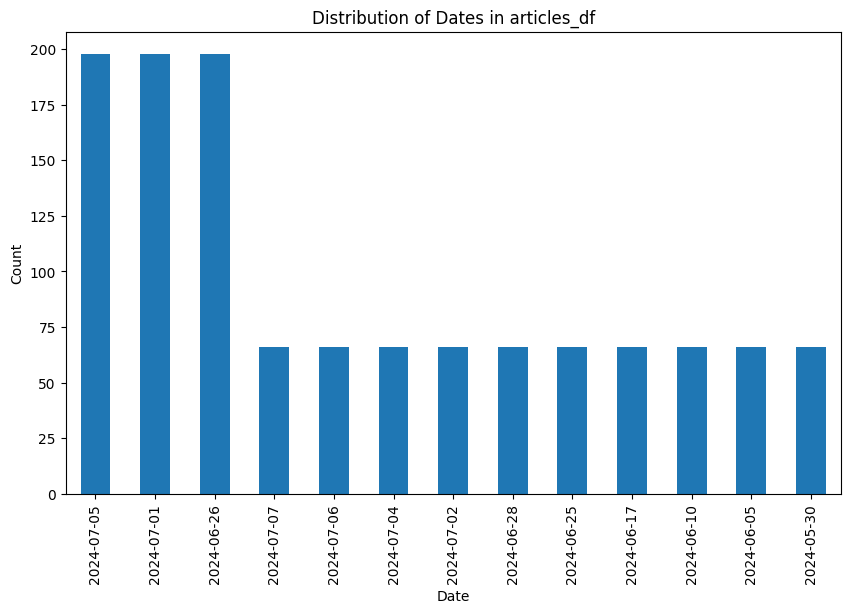

In [7]:
import matplotlib.pyplot as plt

# Count the occurrences of each date
date_counts = articles_df['Date'].value_counts()

# Plot the distribution of dates
plt.figure(figsize=(10, 6))
date_counts.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Distribution of Dates in articles_df')
plt.show()

## Stocks data

In [8]:
import pandas as pd

product_name = 'ICLN'
prices_df = pd.read_csv(f'datasets/{product_name}.csv')

print(f'Number of rows: {prices_df.shape[0]}')
print(f'Missing values: {prices_df["Close"].isnull().sum()}')


# Convert the 'Date' column in prices_df to datetime
prices_df['Date'] = pd.to_datetime(prices_df['Date']).dt.date


# Set 'Date' as the index
prices_df.set_index('Date', inplace=True)

# Reindex to business days to fill missing dates
business_days = pd.bdate_range(start=prices_df.index.min(), end=prices_df.index.max())
prices_df = prices_df.reindex(business_days)

# Fill missing values (e.g., forward fill)
prices_df = prices_df.ffill()

print(f'first date: {prices_df.index.min()}')
print(f'last date: {prices_df.index.max()}')

prices_df.tail()

Number of rows: 4035
Missing values: 0
first date: 2008-06-25 00:00:00
last date: 2024-07-08 00:00:00


,Open,High,Low,Close,Adj Close,Volume
2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0
2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0
2024-07-04,13.36,13.64,13.34,13.59,13.59,4990500.0
2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0
2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0


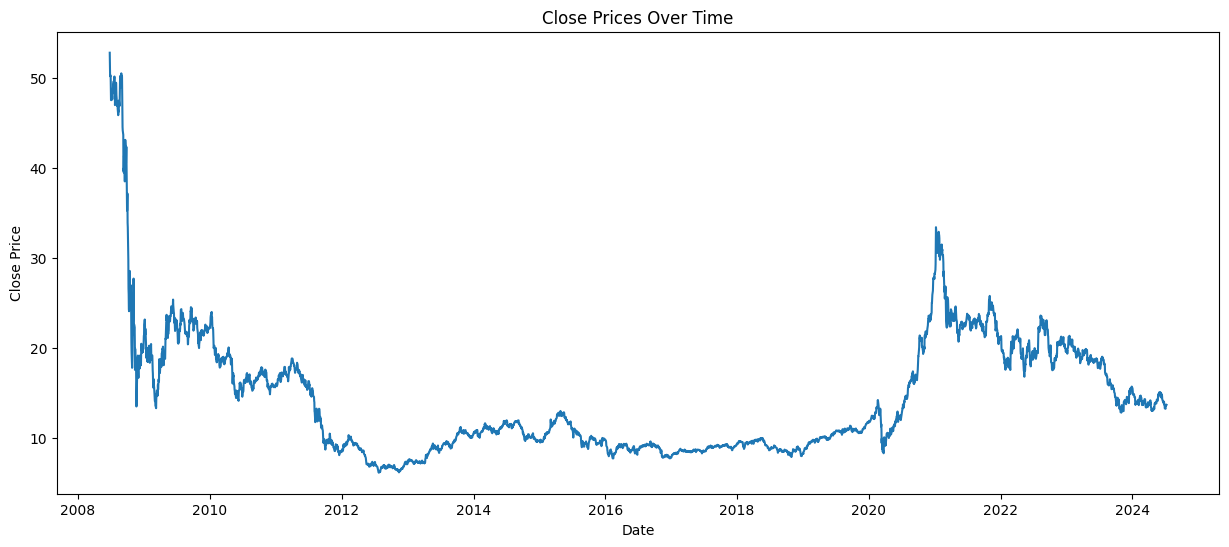

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the 'Close' column
plt.figure(figsize=(15, 6))
sns.lineplot(data=prices_df, x=prices_df.index, y='Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Prices Over Time')
plt.show()


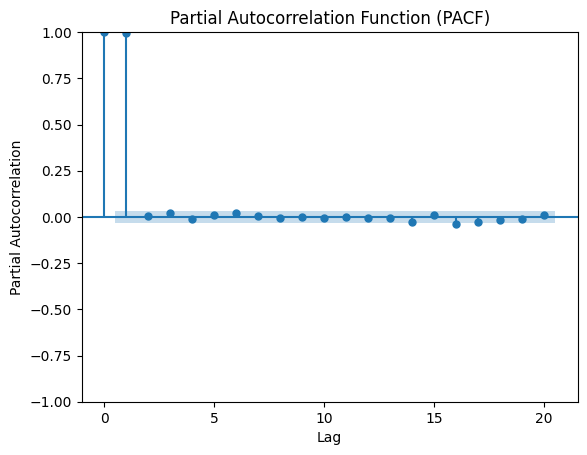

PACF Scores:
Lag 0: 1.0
Lag 1: 0.9948274244337907
Lag 2: 0.007685269278940517
Lag 3: 0.020783250452185896
Lag 4: -0.011007247103308887
Lag 5: 0.013196605613296957
Lag 6: 0.02092465014119933
Lag 7: 0.008025842826474382
Lag 8: -0.0037719900729678182
Lag 9: 0.0020912735979903485
Lag 10: -0.00764786535759519
Lag 11: 0.001916152367227097
Lag 12: -0.007190719388653742
Lag 13: -0.00598314628933709
Lag 14: -0.02693999735114239
Lag 15: 0.01013880884624704
Lag 16: -0.039495888307053334
Lag 17: -0.030240872267815095
Lag 18: -0.01856871882317561
Lag 19: -0.012610656596676886
Lag 20: 0.01075546304462905


In [6]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

# Calculate PACF
pacf_scores = pacf(prices_df['Close'], nlags=20)

# Plot PACF
plot_pacf(prices_df['Close'], lags=20)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Print PACF scores
print("PACF Scores:")
for lag, score in enumerate(pacf_scores):
    print(f"Lag {lag}: {score}")

We can see that Lag 1 prices are the most correlated with the current price

## Additional Features

Technical features

In [9]:
#Lagged Features
# Create lag columns for 'Close', 'Open', 'High', 'Low'
prices_df['Close_Lag1'] = prices_df['Close'].shift(1)
prices_df['Open_Lag1'] = prices_df['Open'].shift(1)
prices_df['High_Lag1'] = prices_df['High'].shift(1)
prices_df['Low_Lag1'] = prices_df['Low'].shift(1)

# Technical Indicators
# Moving Averages
prices_df['SMA_5'] = prices_df['Close'].rolling(window=5).mean()
prices_df['SMA_10'] = prices_df['Close'].rolling(window=10).mean()

# Relative Strength Index (RSI)
def compute_rsi(data, window):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
prices_df['RSI_14'] = compute_rsi(prices_df['Close'], 14)

# Bollinger Bands
prices_df['BB_middle'] = prices_df['Close'].rolling(window=20).mean()
prices_df['BB_std'] = prices_df['Close'].rolling(window=20).std()
prices_df['BB_upper'] = prices_df['BB_middle'] + (prices_df['BB_std'] * 2)
prices_df['BB_lower'] = prices_df['BB_middle'] - (prices_df['BB_std'] * 2)

# Momentum
prices_df['MOM_10'] = prices_df['Close'].diff(10)


Constituents features

In [10]:
import pandas as pd
import os

# Specify the directory where your CSV files are located
directory = 'datasets/Constituents'

# Initialize an empty DataFrame to hold all the merged data
merged_df = pd.DataFrame()

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Assuming all files are CSVs
        file_path = os.path.join(directory, filename)
        # Load the dataset
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        
        # Extract the 'Close' column and rename it based on the file name (or any identifier)
        stock_name = filename.split('.')[0]  # Get stock name from filename
        df = df[['Close']].rename(columns={'Close': f'close_{stock_name}_constituent'})
        
        # Merge the dataset with the main DataFrame
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = merged_df.join(df, how='outer')
prices_df = prices_df.join(merged_df, how='inner')

prices_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,Low_Lag1,...,BB_lower,MOM_10,close_0C2_constituent,close_600900_constituent,close_ED_constituent,close_ENPH_constituent,close_FSLR_constituent,close_ORSTED_constituent,close_VWS_constituent,close_^IBEX_constituent
2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0,13.31,13.40,13.49,13.29,...,13.056839,-0.88,10.7,29.480000,88.970001,95.769997,216.729996,371.200012,160.250000,10912.799805
2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0,13.26,13.26,13.42,13.18,...,13.038680,-0.55,10.7,29.299999,88.709999,99.169998,231.110001,383.600006,162.800003,11056.799805
2024-07-04,13.36,13.64,13.34,13.59,13.59,4990500.0,13.59,13.36,13.64,13.34,...,13.023517,-0.36,10.7,29.389999,NaN,NaN,NaN,389.500000,163.199997,11066.299805
2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0,13.59,13.36,13.64,13.34,...,12.990026,-0.30,10.6,29.389999,89.269997,97.139999,222.119995,399.500000,163.899994,11023.500000
2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0,13.61,13.56,13.73,13.53,...,13.003496,-0.35,10.5,29.920000,88.419998,102.809998,227.119995,387.700012,162.550003,11022.099609


Other ETFs

In [11]:
import pandas as pd
import os

# Specify the directory where your CSV files are located
directory = 'datasets/other ETFs'

# Initialize an empty DataFrame to hold all the merged data
merged_df = pd.DataFrame()

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Assuming all files are CSVs
        file_path = os.path.join(directory, filename)
        # Load the dataset
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        
        # Extract the 'Close' column and rename it based on the file name (or any identifier)
        stock_name = filename.split('.')[0]  # Get stock name from filename
        df = df[['Close']].rename(columns={'Close': f'close_{stock_name}_etf'})
        
        # Merge the dataset with the main DataFrame
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = merged_df.join(df, how='outer')
prices_df = prices_df.join(merged_df, how='inner')

prices_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,Low_Lag1,...,close_600900_constituent,close_ED_constituent,close_ENPH_constituent,close_FSLR_constituent,close_ORSTED_constituent,close_VWS_constituent,close_^IBEX_constituent,close_XLI_etf,close_XLK_etf,close_XLU_etf
2024-07-01,13.40,13.49,13.29,13.31,13.31,3762900.0,13.32,13.66,13.71,13.28,...,29.480000,88.809998,97.260002,222.710007,376.000000,162.100006,11057.000000,120.559998,227.940002,67.669998
2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0,13.31,13.40,13.49,13.29,...,29.480000,88.970001,95.769997,216.729996,371.200012,160.250000,10912.799805,121.220001,229.080002,68.019997
2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0,13.26,13.26,13.42,13.18,...,29.299999,88.709999,99.169998,231.110001,383.600006,162.800003,11056.799805,121.660004,232.169998,68.430000
2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0,13.59,13.36,13.64,13.34,...,29.389999,89.269997,97.139999,222.119995,399.500000,163.899994,11023.500000,121.220001,232.880005,68.550003
2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0,13.61,13.56,13.73,13.53,...,29.920000,88.419998,102.809998,227.119995,387.700012,162.550003,11022.099609,121.370003,234.470001,68.620003


In [12]:
prices_df.to_csv('data.csv', index=True)

## Merge stocks and articles


In [54]:
# Reset the index to ensure 'Date' is a column
prices_df.reset_index(inplace=True)
prices_df.rename(columns={'index': 'Date'}, inplace=True)
# Convert the 'Date' column in prices_df to datetime and extract only the date part
prices_df['Date'] = pd.to_datetime(prices_df['Date']).dt.date
prices_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,Low_Lag1,SMA_5,SMA_10,RSI_14,BB_middle,BB_std,BB_upper,BB_lower,MOM_10
4179,2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0,13.31,13.40,13.49,13.29,13.474,13.721,10.731707,14.1680,0.555580,15.279161,13.056839,-0.88
4180,2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0,13.26,13.26,13.42,13.18,13.450,13.666,25.229358,14.0945,0.527910,15.150320,13.038680,-0.55
4181,2024-07-04,13.36,13.64,13.34,13.59,13.59,4990500.0,13.59,13.36,13.64,13.34,13.414,13.630,29.729730,14.0285,0.502491,15.033483,13.023517,-0.36
4182,2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0,13.59,13.36,13.64,13.34,13.472,13.600,34.545455,13.9825,0.496237,14.974974,12.990026,-0.30
4183,2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0,13.61,13.56,13.73,13.53,13.550,13.565,37.209302,13.9285,0.462502,14.853504,13.003496,-0.35


In [59]:
# Ensure both are of datetime type
prices_df['Date'][0], articles_df['Date'][0]

(datetime.date(2008, 6, 25), datetime.date(2024, 7, 7))

In [117]:
# Merge articles with prices_df on date
merged_df = pd.merge(prices_df, articles_df, on='Date', how='left')

# Aggregate articles by date
aggregated_articles = merged_df.groupby('Date').agg({
    'Title': lambda x: ' '.join(x.dropna()),
    'Description': lambda x: ' '.join(x.dropna())
}).reset_index()

# Merge aggregated articles back with prices_df
final_df = pd.merge(prices_df, aggregated_articles, on='Date', how='left')
final_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,...,SMA_5,SMA_10,RSI_14,BB_middle,BB_std,BB_upper,BB_lower,MOM_10,Title,Description
4160,2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0,13.31,13.40,13.49,...,13.474,13.721,10.731707,14.1680,0.555580,15.279161,13.056839,-0.88,World’s most volatile big stock is rocking Ind...,Indonesia's stock market faces turmoil as PT B...
4161,2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0,13.26,13.26,13.42,...,13.450,13.666,25.229358,14.0945,0.527910,15.150320,13.038680,-0.55,,
4162,2024-07-04,13.36,13.64,13.34,13.59,13.59,4990500.0,13.59,13.36,13.64,...,13.414,13.630,29.729730,14.0285,0.502491,15.033483,13.023517,-0.36,India's solar output grows at slowest pace in ...,Solar power generation in the third-largest pr...
4163,2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0,13.59,13.36,13.64,...,13.472,13.600,34.545455,13.9825,0.496237,14.974974,12.990026,-0.30,Interest subvention likely to push energy effi...,The power ministry has begun discussions on of...
4164,2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0,13.61,13.56,13.73,...,13.550,13.565,37.209302,13.9285,0.462502,14.853504,13.003496,-0.35,,


## Extract Features from the Text


In [118]:
# Fill missing text data with an empty string
final_df['Title'] = final_df['Title'].fillna('')
final_df['Description'] = final_df['Description'].fillna('')

# Combine Title and Description into one text feature
final_df['Text'] = final_df['Title'] + ' ' + final_df['Description']
final_df = final_df.drop(columns=['Title', 'Description'])  # Drop individual text columns if not needed
final_df

,Date,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,Low_Lag1,SMA_5,SMA_10,RSI_14,BB_middle,BB_std,BB_upper,BB_lower,MOM_10,Text
0,2008-07-22,50.470001,51.799999,48.900002,49.200001,35.326126,9500.0,50.130001,49.750000,50.150002,49.520000,49.522000,48.910,62.444788,49.027000,1.380005,51.787009,46.266990,1.250000,
1,2008-07-23,49.610001,49.639999,49.119999,49.160000,35.297413,5000.0,49.200001,50.470001,51.799999,48.900002,49.454000,49.066,62.079071,48.846500,1.064743,50.975986,46.717013,1.560002,
2,2008-07-24,48.529999,48.529999,46.650002,46.959999,33.717789,6500.0,49.160000,49.610001,49.639999,49.119999,48.926000,48.960,46.954603,48.641499,1.009395,50.660289,46.622710,-1.060001,
3,2008-07-25,47.270000,47.509998,46.810001,47.509998,34.112686,2700.0,46.959999,48.529999,48.529999,46.650002,48.592000,48.885,47.764450,48.508999,0.972842,50.454683,46.563316,-0.750000,
4,2008-07-28,46.759998,47.529999,46.759998,47.209999,33.897285,18800.0,47.509998,47.270000,47.509998,46.810001,48.007999,48.683,46.080498,48.356999,0.922703,50.202406,46.511593,-2.020001,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160,2024-07-02,13.260000,13.420000,13.180000,13.260000,13.260000,2154900.0,13.310000,13.400000,13.490000,13.290000,13.474000,13.721,10.731707,14.168000,0.555580,15.279161,13.056839,-0.880000,World’s most volatile big stock is rocking Ind...
4161,2024-07-03,13.360000,13.640000,13.340000,13.590000,13.590000,4990500.0,13.260000,13.260000,13.420000,13.180000,13.450000,13.666,25.229358,14.094500,0.527910,15.150320,13.038680,-0.550000,
4162,2024-07-04,13.360000,13.640000,13.340000,13.590000,13.590000,4990500.0,13.590000,13.360000,13.640000,13.340000,13.414000,13.630,29.729730,14.028500,0.502491,15.033483,13.023517,-0.360000,India's solar output grows at slowest pace in ...
4163,2024-07-05,13.560000,13.730000,13.530000,13.610000,13.610000,2619900.0,13.590000,13.360000,13.640000,13.340000,13.472000,13.600,34.545455,13.982500,0.496237,14.974974,12.990026,-0.300000,Interest subvention likely to push energy effi...


In [119]:
import os
from multiprocessing import Pool
import gc

embeddings_path = f'embeddings/bert_{product_name}_{articles_name}_embeddings.npy'
if not os.path.exists(os.path.dirname(embeddings_path)):
    os.makedirs(os.path.dirname(embeddings_path))

# Tokenize the text data
def encode_texts(texts, tokenizer, max_length):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',  # Updated padding argument
            truncation=True,  # Added truncation argument
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

def get_bert_embeddings_in_batches(input_ids, attention_masks, bert_model, batch_size=16):
    all_embeddings = []
    for i in range(0, len(input_ids), batch_size):
        batch_input_ids = input_ids[i:i+batch_size]
        batch_attention_masks = attention_masks[i:i+batch_size]
        batch_embeddings = bert_model(batch_input_ids, attention_mask=batch_attention_masks)[0][:, 0, :].numpy()
        all_embeddings.append(batch_embeddings)
    return np.vstack(all_embeddings)

if os.path.exists(embeddings_path):
    # Load embeddings from file
    embeddings = np.load(embeddings_path)
    print(f'Loaded embeddings from: {embeddings_path}')
else:
    # Clear TensorFlow session to release GPU memory
    tf.keras.backend.clear_session()

    # Load BERT model and tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    
    # Encode texts
    input_ids, attention_masks = encode_texts(final_df['Text'], tokenizer, max_length=128)

    embeddings = get_bert_embeddings_in_batches(input_ids, attention_masks, bert_model, batch_size=16)

    # Save embeddings to file
    np.save(embeddings_path, embeddings)
    
    # Clean up to release memory
    del input_ids
    del attention_masks
    del bert_model
    del tokenizer
    gc.collect()
    tf.keras.backend.clear_session()

Loaded embeddings from: embeddings/bert_ICLN_green_energy_articles_max_articles_end20220101_embeddings.npy


Reddit Scraper


In [1]:
pip install praw pandas

   ---------------------------------------- 0.0/191.0 kB ? eta -:--:--
   ---- ---------------------------------- 20.5/191.0 kB 640.0 kB/s eta 0:00:01
   -------- ------------------------------ 41.0/191.0 kB 487.6 kB/s eta 0:00:01
   ------------------------- -------------- 122.9/191.0 kB 1.0 MB/s eta 0:00:01
   ---------------------------------------- 191.0/191.0 kB 1.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import praw
import pandas as pd

CLIENT_ID = 'SBqeY_vwoICNj_JebXVe6w'
CLIENT_SECRET = 'mVBreyVTFOdBAK0VKAFHtggcGDRR5w'
USER_AGENT = 'Michael_bot'

reddit = praw.Reddit(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, user_agent=USER_AGENT)

subreddit = reddit.subreddit('ideas')
top_posts = subreddit.top(limit=200)


def count_words(text):
    return len(text.split())


ideas = []
for post in top_posts:
    title = post.title
    text = post.selftext
    total_words = count_words(title) + count_words(text)

    if total_words >= 50:
        idea = {
            'title': title,
            'upvotes': post.score,
            'url': post.url,
            'text': text,
            'total_words': total_words
        }
        ideas.append(idea)

# Print the filtered ideas
for idx, idea in enumerate(ideas, start=1):
    if idx > 0:
        print(f"{idx}. {idea['title']}\nURL: {idea['url']}\nText: {idea['text']}\n")

1. Should prisons be rewarded for criminals who don't re-offend, and fined for those who do?
URL: https://www.reddit.com/r/ideas/comments/1ntd1d/should_prisons_be_rewarded_for_criminals_who_dont/
Text: Right now, prisons are incentivized *not* to rehabilitate prisoners, because it would result in less revenue to the prison. But society wins when a criminal is successfully rehabilitated. I think prisons should share society's gain, like a sort of profit sharing, to fix the conflict of interest. Because this would be would be revenue-neutral (total rewards equal total fines), it wouldn't cost taxpayers anything.

What would be the disadvantages of this strategy?

2. Infinite opps
URL: https://www.reddit.com/r/ideas/comments/11p7ra2/infinite_opps/
Text: Opps getting so rare nowadays that mfs be recruiting them but there is a simple solution that creates an infiniite amount of them. SO yall remember when scientists cloned a sheep or smth anyway why dont we just apply that on humans. Now i 